<a href="https://colab.research.google.com/github/wei-enwang/space-ham/blob/main/main_driver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import nltk
from nltk.corpus import words
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils import data
from preprocess import WholeData, BalancedData

import models
import utils

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/weinwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
nltk.download('words')

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"   # use gpu whenever you can!

seed = 32
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

[nltk_data] Downloading package words to /home/weinwang/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [19]:
plot_yes = True

# use one dataset for now
train_data_dir = "./data/enron1/"
test_data_dir = "./data/enron2/"
output_dir = "./output/"

# hyperparameters
batch_size = 32
hidden_size = 128
num_layer = 3
dropout = 0.5
learning_rate = 1e-4
epochs = 30
max_len = 100

In [20]:
vocab = set([str.lower() for str in words.words()])

# train_dataset = WholeData(train_data_dir, src_vocab=vocab, use_max_len=True, max_len=max_len)
# test_dataset = WholeData(test_data_dir, src_vocab=vocab, use_max_len=True, max_len=max_len)
# Balanced dataset
train_dataset = BalancedData(train_data_dir, src_vocab=vocab, use_max_len=True, max_len=max_len)
test_dataset = BalancedData(test_data_dir, src_vocab=vocab, use_max_len=True, max_len=max_len)

w2idx = train_dataset.src_v2id

embed = utils.load_pretrained_vectors(w2idx, "fastText/crawl-300d-2M.vec")
embed = torch.tensor(embed)

Number of ham emails: 1500, spam emails: 1500
Number of ham emails: 1496, spam emails: 1496
Loading pretrained vectors...
234378


0it [00:00, ?it/s]

There are 75835 / 234379 pretrained vectors found.


In [21]:
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                   num_workers=8, pin_memory=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, 
                                  num_workers=8, pin_memory=True, drop_last=True)


In [22]:
model = models.spam_lstm(hidden_size=hidden_size, pretrained_embedding=embed, dropout=dropout).to(device)
loss_fn = nn.BCEWithLogitsLoss().to(device)
opt = Adam(model.parameters(), lr=learning_rate)

Using pretrained vectors...


  3%|▎         | 1/30 [00:07<03:30,  7.26s/it]

Epoch 0
-------------------------------
Training loss: 0.693054, avg accuracy: 0.500997
Testing loss: 0.693071, avg accuracy: 0.511089


  7%|▋         | 2/30 [00:14<03:23,  7.25s/it]

Epoch 1
-------------------------------
Training loss: 0.685536, avg accuracy: 0.564162
Testing loss: 0.663595, avg accuracy: 0.556116


 10%|█         | 3/30 [00:21<03:15,  7.26s/it]

Epoch 2
-------------------------------
Training loss: 0.414579, avg accuracy: 0.841755
Testing loss: 0.432848, avg accuracy: 0.833333


 13%|█▎        | 4/30 [00:29<03:08,  7.25s/it]

Epoch 3
-------------------------------
Training loss: 0.284611, avg accuracy: 0.916556
Testing loss: 0.395961, avg accuracy: 0.870632


 17%|█▋        | 5/30 [00:36<03:01,  7.26s/it]

Epoch 4
-------------------------------
Training loss: 0.287302, avg accuracy: 0.905807
Testing loss: 0.392570, avg accuracy: 0.870296


 20%|██        | 6/30 [00:43<02:54,  7.26s/it]

Epoch 5
-------------------------------
Training loss: 0.225169, avg accuracy: 0.935949
Testing loss: 0.423741, avg accuracy: 0.868280


 23%|██▎       | 7/30 [00:50<02:46,  7.25s/it]

Epoch 6
-------------------------------
Training loss: 0.202477, avg accuracy: 0.938054
Testing loss: 0.440705, avg accuracy: 0.850470


 27%|██▋       | 8/30 [00:58<02:39,  7.26s/it]

Epoch 7
-------------------------------
Training loss: 0.158060, avg accuracy: 0.954233
Testing loss: 0.454264, avg accuracy: 0.866935


 30%|███       | 9/30 [01:05<02:32,  7.27s/it]

Epoch 8
-------------------------------
Training loss: 0.149711, avg accuracy: 0.950798
Testing loss: 0.491684, avg accuracy: 0.849462


 33%|███▎      | 10/30 [01:12<02:25,  7.26s/it]

Epoch 9
-------------------------------
Training loss: 0.147506, avg accuracy: 0.957004
Testing loss: 0.484212, avg accuracy: 0.867944


 37%|███▋      | 11/30 [01:19<02:18,  7.27s/it]

Epoch 10
-------------------------------
Training loss: 0.159618, avg accuracy: 0.940492
Testing loss: 0.373774, avg accuracy: 0.884073


 40%|████      | 12/30 [01:27<02:10,  7.27s/it]

Epoch 11
-------------------------------
Training loss: 0.109675, avg accuracy: 0.972074
Testing loss: 0.459977, avg accuracy: 0.869960


 43%|████▎     | 13/30 [01:34<02:03,  7.27s/it]

Epoch 12
-------------------------------
Training loss: 0.098302, avg accuracy: 0.971410
Testing loss: 0.426129, avg accuracy: 0.874664


 47%|████▋     | 14/30 [01:41<01:56,  7.26s/it]

Epoch 13
-------------------------------
Training loss: 0.087097, avg accuracy: 0.977061
Testing loss: 0.437741, avg accuracy: 0.878024


 50%|█████     | 15/30 [01:48<01:49,  7.27s/it]

Epoch 14
-------------------------------
Training loss: 0.091899, avg accuracy: 0.972407
Testing loss: 0.442680, avg accuracy: 0.883401


 53%|█████▎    | 16/30 [01:56<01:41,  7.28s/it]

Epoch 15
-------------------------------
Training loss: 0.177509, avg accuracy: 0.925864
Testing loss: 0.369852, avg accuracy: 0.877016


 57%|█████▋    | 17/30 [02:03<01:34,  7.29s/it]

Epoch 16
-------------------------------
Training loss: 0.094384, avg accuracy: 0.975066
Testing loss: 0.379389, avg accuracy: 0.890457


 60%|██████    | 18/30 [02:10<01:27,  7.28s/it]

Epoch 17
-------------------------------
Training loss: 0.083721, avg accuracy: 0.977948
Testing loss: 0.376289, avg accuracy: 0.862567


 63%|██████▎   | 19/30 [02:18<01:20,  7.28s/it]

Epoch 18
-------------------------------
Training loss: 0.073948, avg accuracy: 0.980386
Testing loss: 0.356659, avg accuracy: 0.892473


 67%|██████▋   | 20/30 [02:25<01:12,  7.28s/it]

Epoch 19
-------------------------------
Training loss: 0.066570, avg accuracy: 0.984264
Testing loss: 0.451870, avg accuracy: 0.857527


 70%|███████   | 21/30 [02:32<01:05,  7.28s/it]

Epoch 20
-------------------------------
Training loss: 0.074455, avg accuracy: 0.979721
Testing loss: 0.434212, avg accuracy: 0.868280


 73%|███████▎  | 22/30 [02:39<00:58,  7.28s/it]

Epoch 21
-------------------------------
Training loss: 0.058093, avg accuracy: 0.985040
Testing loss: 0.386296, avg accuracy: 0.894825


 77%|███████▋  | 23/30 [02:47<00:50,  7.28s/it]

Epoch 22
-------------------------------
Training loss: 0.045135, avg accuracy: 0.989916
Testing loss: 0.418860, avg accuracy: 0.893481


 80%|████████  | 24/30 [02:54<00:43,  7.28s/it]

Epoch 23
-------------------------------
Training loss: 0.043508, avg accuracy: 0.990691
Testing loss: 0.455409, avg accuracy: 0.891801


 83%|████████▎ | 25/30 [03:01<00:36,  7.28s/it]

Epoch 24
-------------------------------
Training loss: 0.042624, avg accuracy: 0.991356
Testing loss: 0.432908, avg accuracy: 0.891465


 87%|████████▋ | 26/30 [03:09<00:29,  7.28s/it]

Epoch 25
-------------------------------
Training loss: 0.057935, avg accuracy: 0.984707
Testing loss: 0.386323, avg accuracy: 0.891465


 90%|█████████ | 27/30 [03:16<00:21,  7.27s/it]

Epoch 26
-------------------------------
Training loss: 0.036903, avg accuracy: 0.993019
Testing loss: 0.409990, avg accuracy: 0.898522


 93%|█████████▎| 28/30 [03:23<00:14,  7.28s/it]

Epoch 27
-------------------------------
Training loss: 0.035595, avg accuracy: 0.993240
Testing loss: 0.413017, avg accuracy: 0.897849


 97%|█████████▋| 29/30 [03:30<00:07,  7.27s/it]

Epoch 28
-------------------------------
Training loss: 0.039185, avg accuracy: 0.991578
Testing loss: 0.509289, avg accuracy: 0.877688


100%|██████████| 30/30 [03:38<00:00,  7.27s/it]

Epoch 29
-------------------------------
Training loss: 0.033138, avg accuracy: 0.993019
Testing loss: 0.495292, avg accuracy: 0.881384


Final testing loss: 0.496250, testing accuracy: 0.881048
F1 score: 0.874912 Precision: 0.923881, Recall: 0.830872


(0.033138364905174425, 0.4962502964321644)

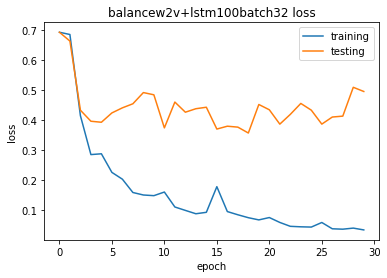

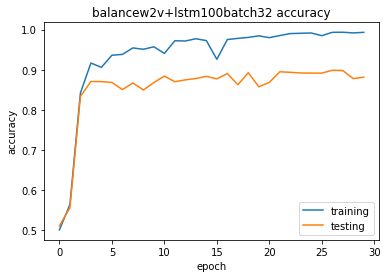

In [23]:
utils.train_test_scheme(train_dataloader, test_dataloader, model, loss_fn, opt, 
                        task_name="balancew2v+lstm100batch32", epochs=epochs, 
                        vis=plot_yes, print_every=1, img_dir=output_dir)



In [24]:
torch.save(model.state_dict(), output_dir+"balancew2v_lstm100batch32.pt")

In [28]:
test_message = "Subject: Look, I understand everything, but this is a frank bust... Look here and tell me your opinion"

In [29]:
from preprocess import clean_string
context = clean_string(test_message)
sent_id = [0 for _ in range(max_len)]
for i, w in enumerate(context):
    if i >= max_len:
        break
    if w not in train_dataset.vocab:
        w = '<unk>'
    sent_id[i] = train_dataset.src_v2id[w]
sent_id = torch.unsqueeze(torch.tensor(sent_id),dim=0).to(device)

In [30]:
model.eval()
print(f"Email message: \"{test_message}\"")
with torch.no_grad():
    pred = nn.Sigmoid()(model(sent_id))
    pred = torch.squeeze(pred)

    if pred > 0.5:
        print("This is a ham email message.")
    else:
        print("This is a spam email message.")

print(f"The probability of this email being a spam is {(1-pred)*100:.1f}%.")

Email message: "Subject: Look, I understand everything, but this is a frank bust... Look here and tell me your opinion"
This is a spam email message.
The probability of this email being a spam is 97.6%.
